In [1]:
from GAEModel import GAEModel
import torch
import torch.nn as nn 
from torch_geometric.datasets import DBP15K
from torch_geometric.data import Data
import torch_geometric.transforms as T 
from torch_geometric.utils import train_test_split_edges


In [2]:
dataset= DBP15K(root="DATA/dnp15k",pair="en_zh",transform=T.NormalizeFeatures())
data=dataset[0]
data=Data(x=data.x1,edge_index=data.edge_index1,edge_attr=data.rel1)
data

Data(x=[19572, 13, 300], edge_index=[2, 95142], edge_attr=[95142])

In [3]:
x=data.x.view(19572,3900)
x=torch.cat([x[data.edge_index[0]],data.edge_attr.unsqueeze(1)],dim=1)


In [4]:
data=train_test_split_edges(data)


c:\anaconda\envs\pytorch\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


In [5]:
data.x=x

In [6]:
data.num_features

3901

In [7]:
from torch_geometric.nn import VGAE
from torch_geometric.nn import GCNConv


class VariationalGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(VariationalGCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True) # cached only for transductive learning
        self.conv_mu = GCNConv(2 * out_channels, out_channels, cached=True)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)

In [10]:
out_channels = 20
num_features = data.num_features
epochs = 400


model = VGAE(VariationalGCNEncoder(num_features, out_channels))  # new line

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
x = data.x.to(device)
train_pos_edge_index = data.train_pos_edge_index.to(device)
val_pos_edge_index=data.val_pos_edge_index.to(device)
test_pos_edge_index=data.test_pos_edge_index.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [12]:
def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(x, train_pos_edge_index)
    loss = model.recon_loss(z, train_pos_edge_index)
    
    loss = loss + (1 / data.num_nodes) * model.kl_loss()  # new line
    loss.backward()
    optimizer.step()
    return float(loss)


def test(test,pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, test)
    return model.test(z, pos_edge_index, neg_edge_index)

In [13]:
from torch.utils.tensorboard import SummaryWriter
from  tqdm.auto import tqdm

writer = SummaryWriter('runs/VGAE_experiment_Dbp15k_edgeatt'+'20d_400_epochs_2')

for epoch in tqdm(range(1, epochs + 1)):
    loss = train()
    auc, ap = test(test_pos_edge_index,data.test_pos_edge_index, data.test_neg_edge_index)
    #print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))
    #tqdm.set_description(f'Epoch {str(epoch)}, Train Loss: {str(loss)}, Train AP: {str(ap)}, auc: {str(auc)}')
    
    writer.add_scalar('auc train',auc,epoch) # new line
    writer.add_scalar('ap train',ap,epoch)   # new line
    writer.add_scalar('loss',loss,epoch)



  0%|          | 0/400 [00:00<?, ?it/s]

In [14]:
torch.save(model.state_dict(), 'models/VGAE_experiment_DBP15k+edheatt'+'20d_400_epochs')

In [16]:
latent_space=model.encode(data.x,train_pos_edge_index)
latent_space = latent_space.detach().numpy()

In [17]:
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np


dbscan = DBSCAN(eps=0.5, min_samples=5)
cluster_labels = dbscan.fit_predict(latent_space)

# Apply t-SNE dimensionality reduction technique to reduce the dimensionality of the latent space embeddings
tsne = TSNE(n_components=3, perplexity=30, random_state=0)
tsne_embeddings = tsne.fit_transform(latent_space)

# Plot the reduced embeddings and color code the points based on their cluster assignments
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=cluster_labels)
plt.show()


KeyboardInterrupt: 

c:\anaconda\envs\pytorch\lib\site-packages\matplotlib\collections.py:967: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


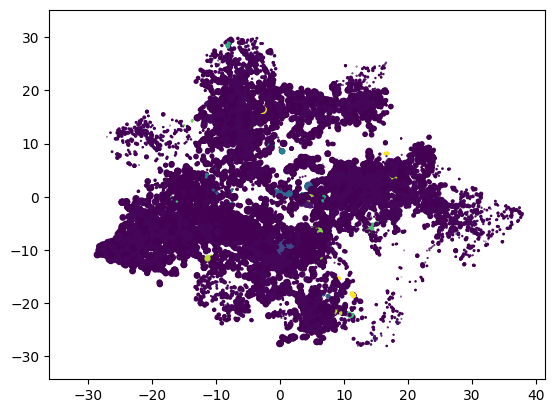

In [ ]:
tsne = TSNE(n_components=3, perplexity=30, random_state=0)
tsne_embeddings = tsne.fit_transform(latent_space)

# Plot the reduced embeddings and color code the points based on their cluster assignments
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1],tsne_embeddings[:,2], c=cluster_labels)
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score
silhouette_score(latent_space, cluster_labels)

-0.40709963

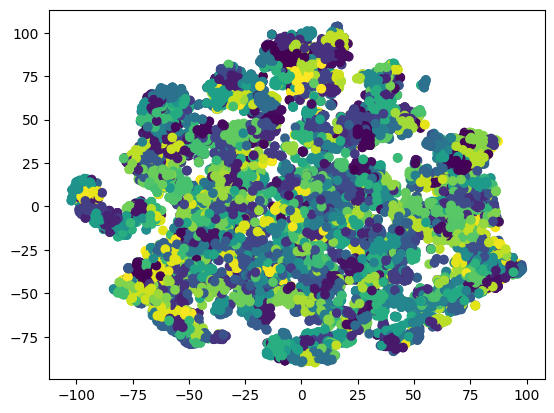

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=320, random_state=0, n_init="auto")

cluster_labels = kmeans.fit_predict(latent_space)
# Apply t-SNE dimensionality reduction technique to reduce the dimensionality of the latent space embeddings
tsne = TSNE(n_components=2, perplexity=30, random_state=0)
tsne_embeddings = tsne.fit_transform(latent_space)

# Plot the reduced embeddings and color code the points based on their cluster assignments
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=cluster_labels)
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score
silhouette_score(latent_space, cluster_labels)

0.11059322